In [1]:
# all imports
import argparse
import numpy as np
import pandas as pd
import models.autoencoder as vae
import models.nfl as nfl
import models.credence as credence
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from common.utils import sample_hyperparameter, save_params
from common.evaluate import *
from datetime import datetime
import os

In [2]:
# define function for showing probability distributions

def view_distribution(gt_df, generated_df, colnames, chart_path, figsize = (15,30)):

    # print(X[:,0].shape, generated_df[1]["X1"].shape)
    # print('true value range', X[:, 0].min(), X[:, 0].max())
    # print('gen value range', generated_df[0]["X1"].min(), generated_df[0]["X1"].max())

    #plt.show()
    nrows = len(colnames)
    size = figsize
    fig,ax = plt.subplots(nrows=nrows,ncols=2,figsize=size)
    

    for i,yvar in enumerate(colnames):
        sns.kdeplot(gt_df[yvar], ax = ax[i,0], fill = True)
        ax[i,0].set_title(f'Observed {yvar}')
        sns.kdeplot(generated_df[yvar], ax = ax[i,1], fill = True)
        ax[i,1].set_title(f'Generated {yvar}')
    
    plt.savefig(chart_path)

    #plt.show()


In [3]:
# conduct experiment

def use_modified_credence(gt_df, x_vars, y_vars, out_vars, treat_vars, categorical_vars, num_vars, sample_params):
    nfl_obj = nfl.NFL(
        data = gt_df,
        outcome_var = out_vars,
        treatment_var = treat_vars,
        categorical_var = categorical_vars,
        numerical_var=x_vars+num_vars
    )
    #sample_params = sample_hyperparameter(['kld_rigidity'], [(0.0,1.0)])
    #max_epochs = 5 
    #print('\n\nHyperparameters')
    #print('kld rigidity:', sample_params['kld_rigidity'])
    #print('max epochs', max_epochs, '\n\n')
    gen_models = nfl_obj.fit(latent_dim = 4, hidden_dim = [8,16,8], kld_rigidity = sample_params['kld_rigidity'], max_epochs = sample_params['max_epochs'])

    # generated samples
    generated_df, generated_df_prime = nfl_obj.sample()
    generated_df_prime['Y'] = (generated_df_prime['A'] * generated_df_prime['Y1']) + ((1 - generated_df_prime['A']) * generated_df_prime['Y0'])
    generated_df_prime['Y_cf'] = (generated_df_prime['A'] * generated_df_prime['Yprime1']) + ((1 - generated_df_prime['A']) * generated_df_prime['Yprime0'])
    experiment_name = "exp-{:%Y%m%d%H%M%S}".format(datetime.now())
    output_dir = os.path.join(os.getcwd(), './outputs/modified-credence')
    exp_dir = os.path.join(output_dir, experiment_name)
    if not(os.path.exists(exp_dir)):
        os.mkdir(exp_dir)

    filename = f'{experiment_name}-Y'
    chart_path = os.path.join(exp_dir, filename)
    params_path = os.path.join(exp_dir, f'{experiment_name}-params.txt')
    view_distribution(gt_df, generated_df_prime, y_vars, chart_path, (10,10))
    save_params(sample_params, params_path)
    #print(generated_df_prime['Y'].shape, gt_df['Y'].shape, generated_df_prime['Y_cf'].shape, gt_df['Y_cf'].shape)
    #fids = fid_score(gt_df, generated_df_prime, y_vars)
    #iss = inception_score(generated_df_prime, y_vars)
    #print('FID score: ', fids)
    #print('Inception score: ', iss)


def use_credence(gt_df, x_vars, y_vars, out_vars, treat_vars, categorical_vars, num_vars, sample_params):
    cred_obj = credence.Credence(
        data = gt_df,
        outcome_var = out_vars,
        treatment_var = treat_vars,
        categorical_var = categorical_vars,
        numerical_var=x_vars+num_vars
    )
    #sample_params = sample_hyperparameter(['kld_rigidity'], [(0.0,1.0)])
    #max_epochs = 5
    #print('\n\nHyperparameters')
    #print('kld rigidity:', sample_params['kld_rigidity'])
    #print('max epochs', max_epochs, '\n\n')
    gen_models = cred_obj.fit(latent_dim = 4, hidden_dim = [8,16,8], kld_rigidity = sample_params['kld_rigidity'], max_epochs = sample_params['max_epochs'])

    # generated samples
    generated_df, generated_df_prime = cred_obj.sample()
    generated_df_prime['Y'] = (generated_df_prime['A'] * generated_df_prime['Y1']) + ((1 - generated_df_prime['A']) * generated_df_prime['Y0'])
    generated_df_prime['Y_cf'] = (generated_df_prime['A'] * generated_df_prime['Yprime1']) + ((1 - generated_df_prime['A']) * generated_df_prime['Yprime0'])

    experiment_name = "exp-{:%Y%m%d%H%M%S}".format(datetime.now())
    output_dir = os.path.join(os.getcwd(), './outputs/credence')
    exp_dir = os.path.join(output_dir, experiment_name)
    if not(os.path.exists(exp_dir)):
        os.mkdir(exp_dir)

    filename = f'{experiment_name}-X'
    params_path = os.path.join(exp_dir, f'{experiment_name}-params.txt')
    chart_path = os.path.join(exp_dir, filename)
    view_distribution(gt_df, generated_df_prime, x_vars, chart_path, (25,50))
    filename = f'{experiment_name}-Y'
    chart_path = os.path.join(exp_dir, filename)
    view_distribution(gt_df, generated_df_prime, y_vars, chart_path, (10,10))
    save_params(sample_params, params_path)
    #print(generated_df_prime['Y'].shape, gt_df['Y'].shape)
    #fids = fid_score(gt_df, generated_df_prime, y_vars)
    #iss = inception_score(generated_df_prime, y_vars)
    #print('FID score: ', fids)
    #print('Inception score: ', iss)


In [4]:
def run_experiment(sample_params, dataset_type, framework_type):
    if dataset_type == 'toy':
    # generating toy dataset
        X = np.random.normal(0, 1, (2000, 5))
        Y0 = np.random.normal(np.sum(X,axis=1),1)
        T = np.random.binomial(1,0.5,size=(X.shape[0],))
        Y1 = Y0**2 + np.random.normal(np.mean(X,axis=1),5)
        Y = T*Y1 + (1 - T)*Y0
        xnames = ['X%d'%(i) for i in range(X.shape[1])]
        ynames = ['Y', 'Y_cf']

        gt_df = pd.DataFrame(X, columns=['X%d'%(i) for i in range(X.shape[1])])
        gt_df['Y'] = T*Y1 + (1 - T)*Y0
        gt_df['T'] = T

        if framework_type == 'modified_credence':
            print("\nRunning modified credence")
            use_modified_credence(gt_df, xnames, ynames, ['Y'], ['T'], ['T'], ['Y'], sample_params)
        elif framework_type == 'credence':
            print("\nRunning credence")
            use_credence(gt_df, xnames, ynames, ['Y'], ['T'], ['T'], ['Y'], sample_params)
        else:
            SystemExit('Invalid framework type provided')
    elif dataset_type == 'acic19_linear':
        gt_df = pd.read_csv('./data/datasets/acic19_low_dim_1_linear.csv')

        x_vars = ['V%d'%(i) for i in range(1,11)]
        y_vars = ['Y', 'Y_cf']

        if framework_type == 'modified_credence':
            print("\nRunning modified credence")
            use_modified_credence(gt_df, x_vars, y_vars, ['Y'], ['A'], ['A'], ['Y'], sample_params)
        elif framework_type == 'credence':
            print("\nRunning Credence")
            use_credence(gt_df, x_vars, y_vars, ['Y'], ['A'], ['A'], ['Y'], sample_params)
        else:
            SystemExit('Invalid framework type provided')
    elif dataset_type == 'acic19_polynomial':
        gt_df = pd.read_csv('./data/datasets/acic19_low_dim_1_polynomial.csv')

        x_vars = ['V%d'%(i) for i in range(1,11)]
        y_vars = ['Y', 'Y_cf']

        if framework_type == 'modified_credence':
            print("\n\n\nRunning modified credence")
            use_modified_credence(gt_df, x_vars, y_vars, ['Y'], ['A'], ['A'], ['Y'], sample_params)
        elif framework_type == 'credence':
            print("\n\n\nRunning credence")
            use_credence(gt_df, x_vars, y_vars, ['Y'], ['A'], ['A'], ['Y'], sample_params)
        else:
            SystemExit('Invalid framework type provided')
    else:
        SystemExit('Invalid dataset value provided!')

In [5]:
# define datasets
#w = widgets.IntSlider()
datasets = ['acic19_linear', 'acic19_polynomial', 'toy']
wd = widgets.Dropdown(
    options=datasets,
    value='acic19_linear',
    description='Dataset:',
)
#frameworks = ['nfl', 'credence']
#wf = widgets.Dropdown(
    #options = frameworks,
    #value = 'nfl', 
    #description = 'Framework: '
#)
display(wd)
#display(wf)
dataset_type = wd.value
#framework_type = wf.value


Dropdown(description='Dataset:', options=('acic19_linear', 'acic19_polynomial', 'toy'), value='acic19_linear')

In [6]:
sample_params = sample_hyperparameter(['kld_rigidity'], [(0.0,0.3)])
sample_params['max_epochs'] = 3

print('Hyperparameters:')
print(sample_params)
print('Dataset to be used: ', wd.value)


Hyperparameters:
{'kld_rigidity': 0.045820331911931286, 'max_epochs': 3}
Dataset to be used:  acic19_linear


/work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.conda/envs/mlprojects/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.co ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Running modified credence


/work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.conda/envs/mlprojects/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /work/pi_jensen_umass_edu/vmuralikrish_umass_edu/playground/nofl-pg/lightning_logs/version_25734407/checkpoints exists and is not empty.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | encoder   | Sequential | 296    | train
1 | en_mu     | Linear     | 36     | train
2 | en_logvar | Linear     | 36     | train
3 | decoder   | Sequential | 400    | train
4 | decode_Y  | Linear     | 9      | train
-------------------------------------------------
777       Trainable params
0         Non-trainable params
777       Total params
0.003     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
/work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.conda/envs/mlprojects/lib/python3.11/site-packages/pytorch_lightning/trainer/con

no of samples:  668


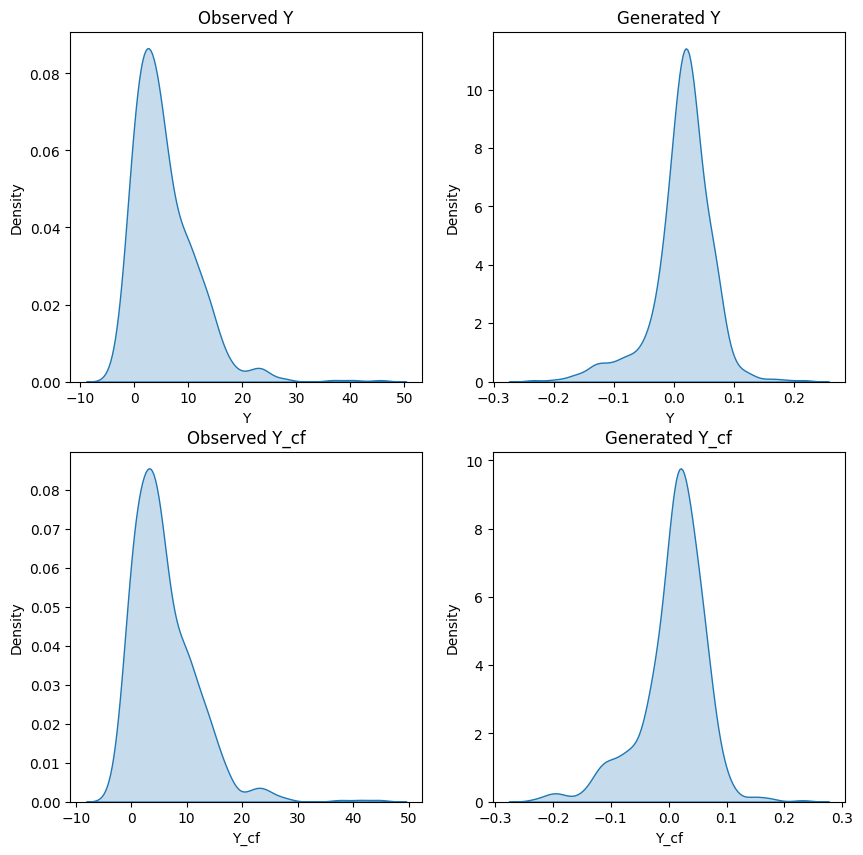

In [7]:
#running modified credence
run_experiment(sample_params, wd.value, 'modified_credence')

/work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.conda/envs/mlprojects/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.co ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.conda/envs/mlprojects/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /work/pi_jensen_umass_edu/vmuralikrish_umass_edu/playground/nofl-pg/lightning_logs/version_25734407/checkpoints exists and is not empty.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | encoder   | Sequential | 296    | train
1 | en_mu     | Linear     | 36     | train
2 | e


Running Credence


/work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.conda/envs/mlprojects/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
`Trainer.fit` stopped: `max_epochs=3` reached.
/work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.conda/envs/mlprojects/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.co ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.conda/envs/mlprojects/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Ch

no of samples:  668


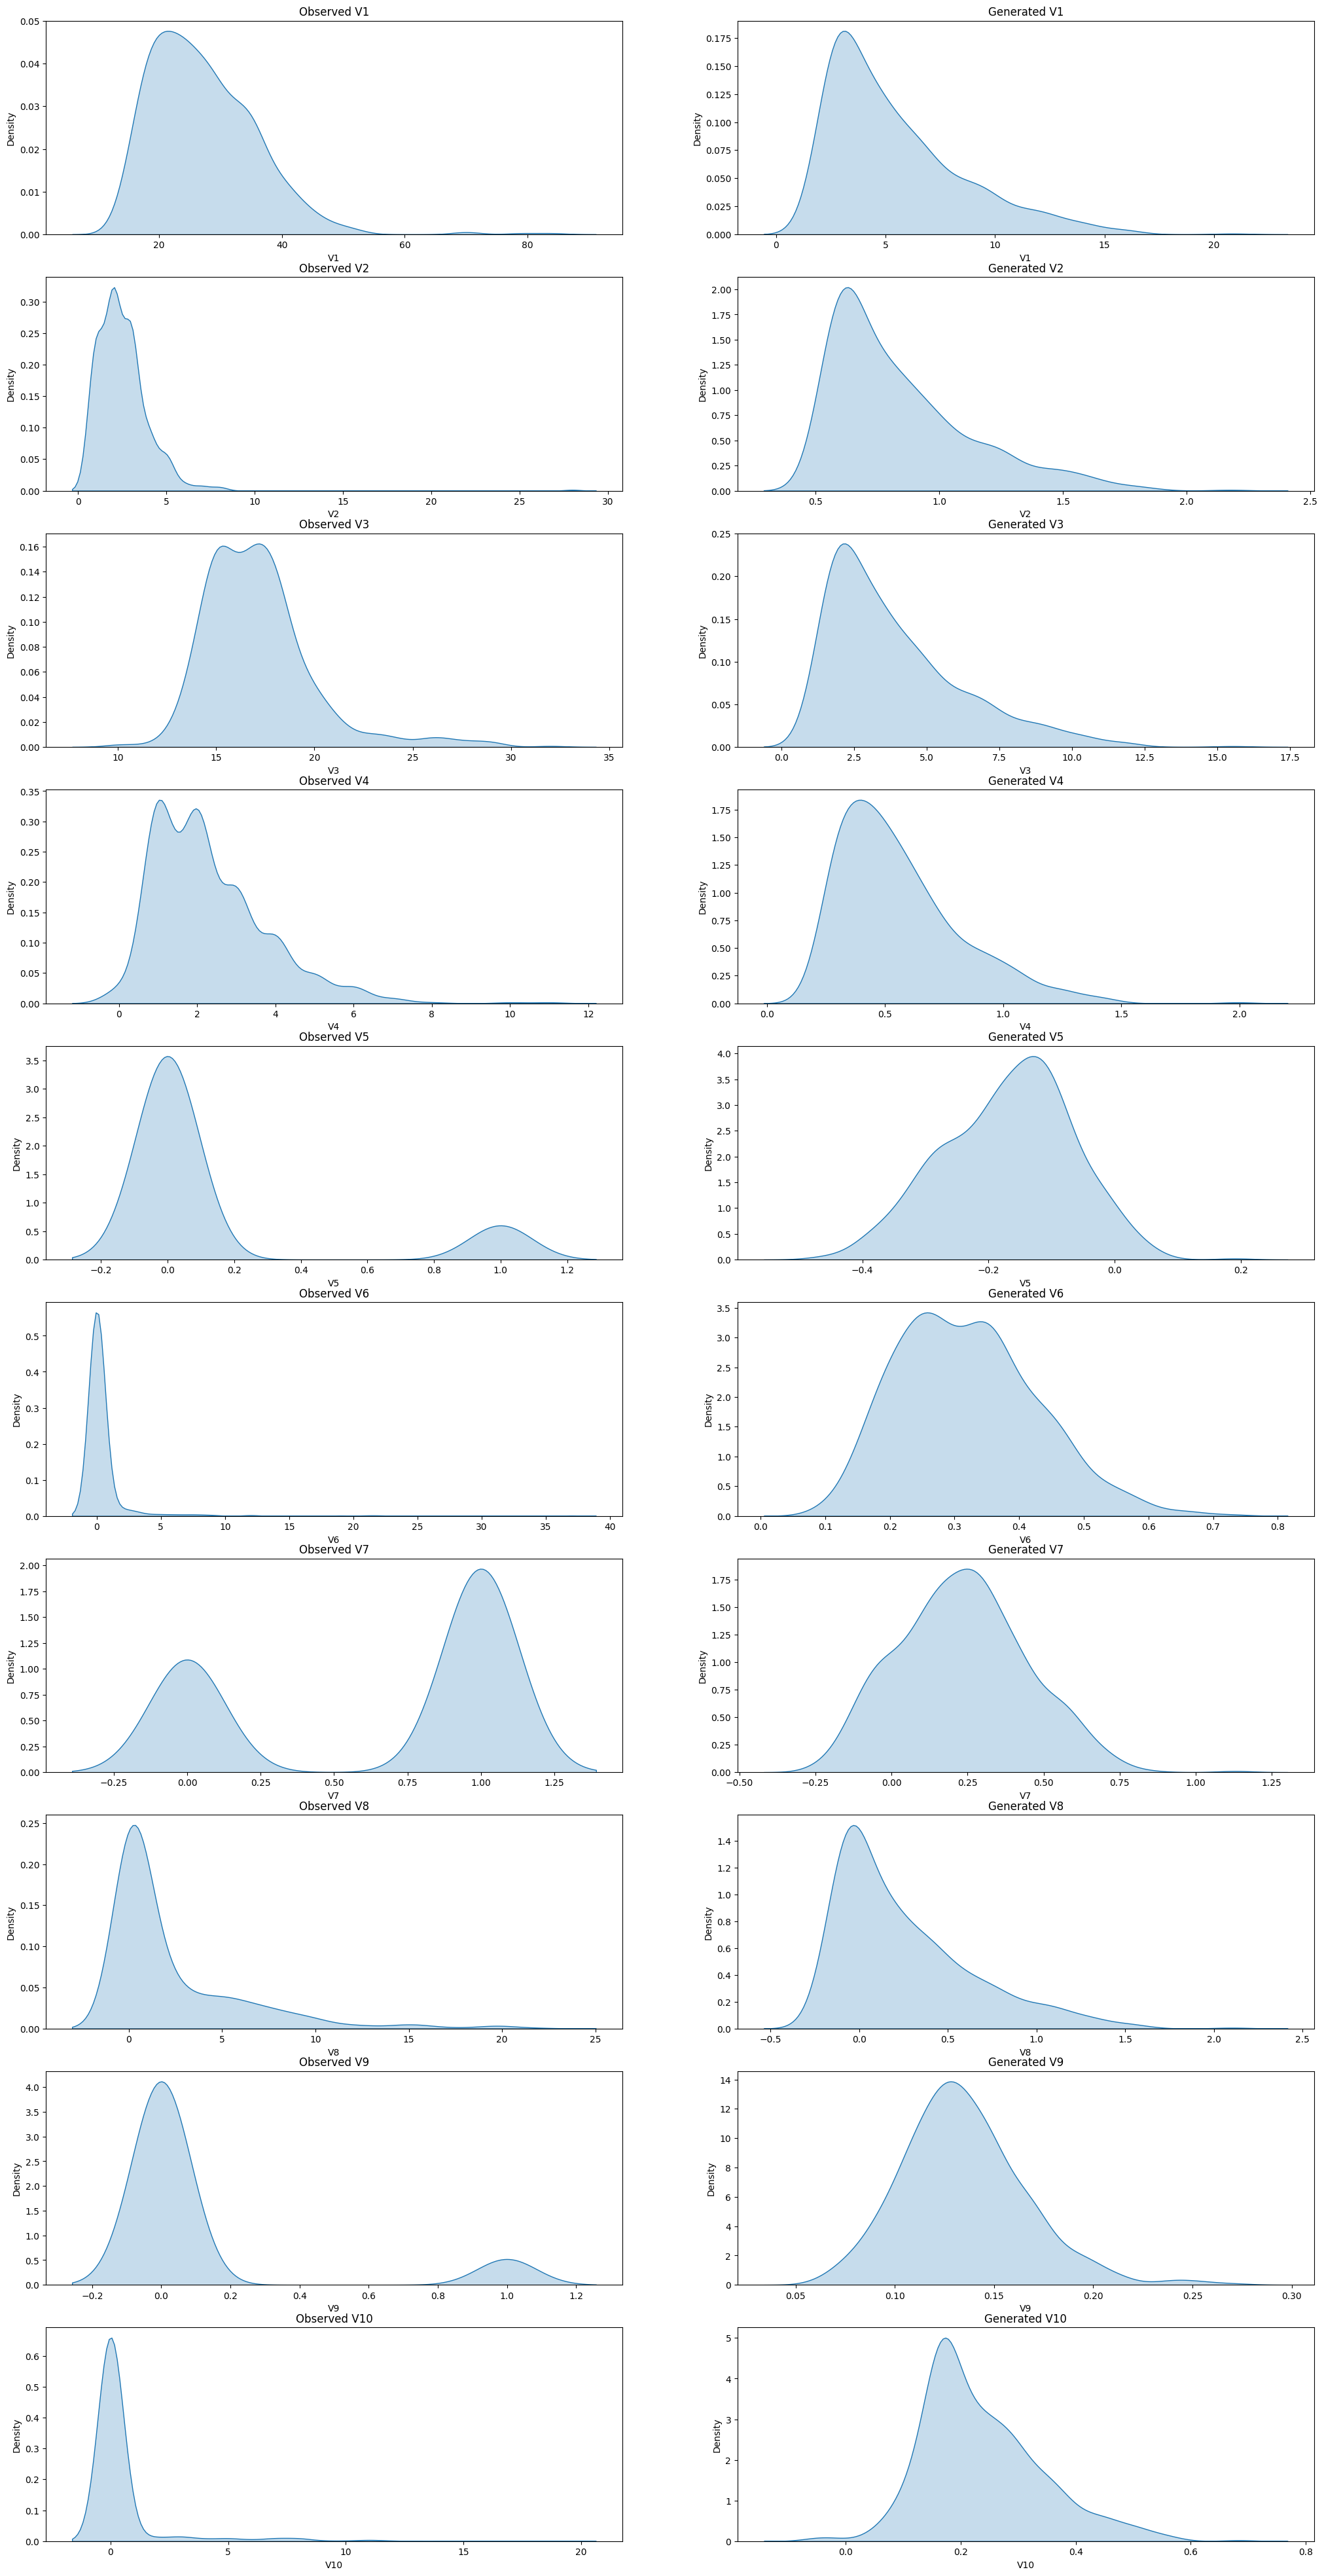

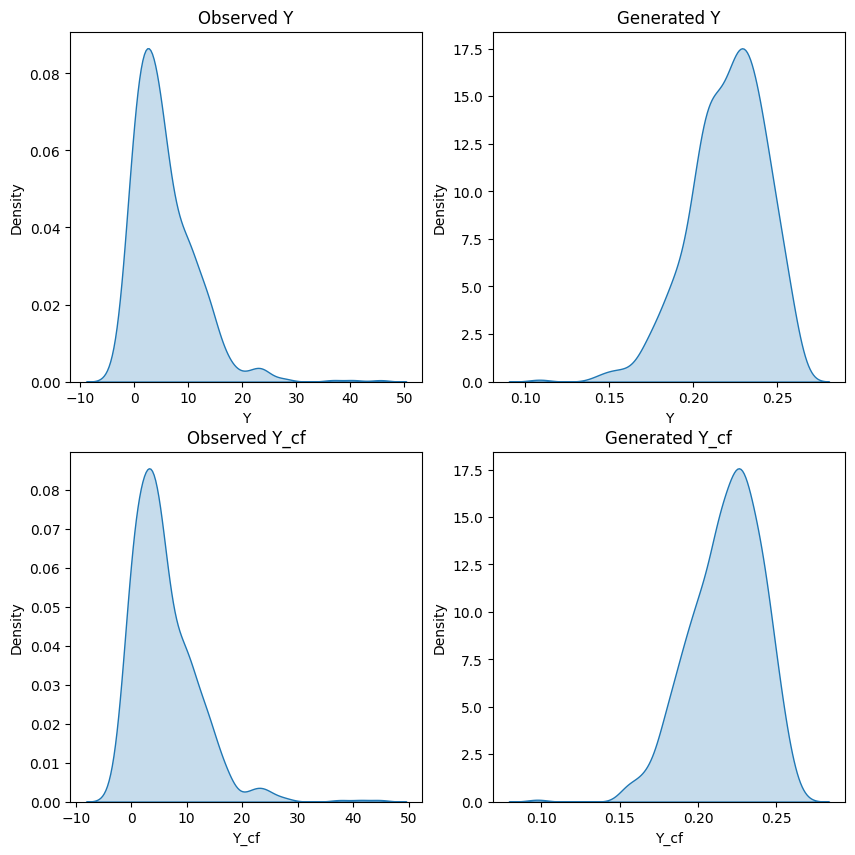

In [8]:
#running modified credence
run_experiment(sample_params, wd.value, 'credence')